In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob
from functools import partial

from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore
from RaTag.scripts.analyse_field_scans import * # type: ignore
from scipy.optimize import curve_fit

# Recommended rcParams for larger font sizes
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 18


In [147]:
def save_area_array(area_array, out_path):
    np.save(out_path, area_array)

# Define Gaussian function
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-(x - mean)**2 / (2 * sigma**2))

def fit_and_plot_gaussian(hist_data, bins, label=None, color=None, mask_range=(-4, 5)):
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    mask = (bin_centers > mask_range[0]) & (bin_centers < mask_range[1])
    popt, pcov = curve_fit(gaussian, bin_centers[mask], hist_data[mask], p0=[np.max(hist_data), np.mean(bin_centers[mask]), np.std(bin_centers[mask])])
    plt.bar(bins[:-1], hist_data, width=np.diff(bins), alpha=0.5, label=label, color=color)
    plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', label=f'Gaussian fit {label}')
    plt.legend()
    return popt, pcov


In [142]:
def load_waveform(file):
    wf = wfm2read(file)
    t, V = wf[1], -wf[0]
    return t, V
    
def subtract_baseline(t, V, t_window=(-1.5e-5, -1.0e-5), v_window=(-0.002, 0.002)):
    baseline_window = (t > t_window[0]) & (t < t_window[1])
    if v_window is not None:
        baseline_window &= (V > v_window[0]) & (V < v_window[1])
    baseline = np.min(V[baseline_window])
    V -= baseline
    return V

def integrate_s2(t, V, s2_lowcut=0.5e-5, s2_upcut=1.5e-5):
    s2_window = (t > s2_lowcut) & (t < s2_upcut)
    area_s2 = np.trapz(V[s2_window], t[s2_window]) * 1e6 / 1e-3  # mV/us

    return area_s2

def extract_s2_areas(files, threshold_bs = 0.05, integ_window=(0.5e-5, 1.5e-5), bs_t_window=(-1.5e-5, -1.0e-5), bs_v_window=None):
    areas = []
    for f in files:
        t, V = load_waveform(f)

        # 1) Reject on “too large signal in baseline window”
        baseline_mask = (t > bs_t_window[0]) & (t < bs_t_window[1])
        V_w = V[baseline_mask]
        if (V_w > threshold_bs).sum() > 5:
            continue

        # 2) Baseline‐subtract
        V_corr = subtract_baseline(t, V, bs_t_window, bs_v_window)

        # 3) Integrate S2
        area = integrate_s2(t, V_corr, integ_window[0], integ_window[1])
        areas.append(area)

    return np.array(areas)

def apply_hist_cuts(arr, lowcut, upcut):
    return arr[(arr > lowcut) & (arr < upcut)]

def analyse_field_scan(base_dir, voltage_pairs, pattern = None, s2_cuts = (1e-6, 1.5e-5),
                       hist_cuts = (-5, 20), nbins = 120):
    # Drift field scan (vary both voltages together)
    if pattern is None:
        pattern = 'FieldScan_1GSsec_EL{}_Gate{}'
    glob_pattern = pattern + '/*.wfm'
    s2_lowcut, s2_upcut = s2_cuts
    hist_lowcut, hist_upcut = hist_cuts

    s2_areas = {}
    s2_areas_cuts = {}
    for el_v, gate_v in voltage_pairs:
        path = os.path.join(base_dir, glob_pattern.format(el_v, gate_v))
        files = sorted(glob(path))
        print(f'Integrating {len(files)} files for EL {el_v} V, Gate {gate_v} V')
        arr = extract_s2_areas(files, integ_window=(s2_lowcut, s2_upcut))
        s2_areas[(el_v, gate_v)] = arr
        s2_areas_cuts[(el_v, gate_v)] = apply_hist_cuts(arr, hist_lowcut, hist_upcut)

        area_out_path = os.path.join(base_dir, pattern.format(el_v, gate_v), f'area_s2_EL{el_v}_Gate{gate_v}.npy')
        save_area_array(arr, area_out_path)

    # Plot all histograms together
    plt.figure(figsize=(8, 6))
    for (el_v, gate_v) in voltage_pairs:
        label = f"$E_{{drift}}$: {round(gate_v/1.4)} V/cm, $V_{{anode}}$: {el_v} V"
        plt.hist(s2_areas_cuts[(el_v, gate_v)], bins=nbins, alpha=0.5, label=label)
    plt.xlabel('S2 Area (mV*us)')
    plt.ylabel('Counts')
    plt.title('Drift field scan, EL field: 1.75 kV/cm')
    plt.legend(fontsize=10)
    return s2_areas_cuts, s2_areas
    # plt.savefig(os.path.join(base_dir, 'field_scan_all.png'))


# Plot waveform and windows

In [5]:
trigger_file = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL3kVcm/sca_waveform.wfm'
trig = wfm2read(trigger_file, verbose=False)
trig_x, trig_y = trig[1], trig[0]
trig_y = trig_y / (10 * np.max(trig_y))

In [6]:
path = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL3kVcm/FieldScan_1GSsec_EL2450_Gate50'
files05 = sorted(glob(os.path.join(path, '*.wfm')))

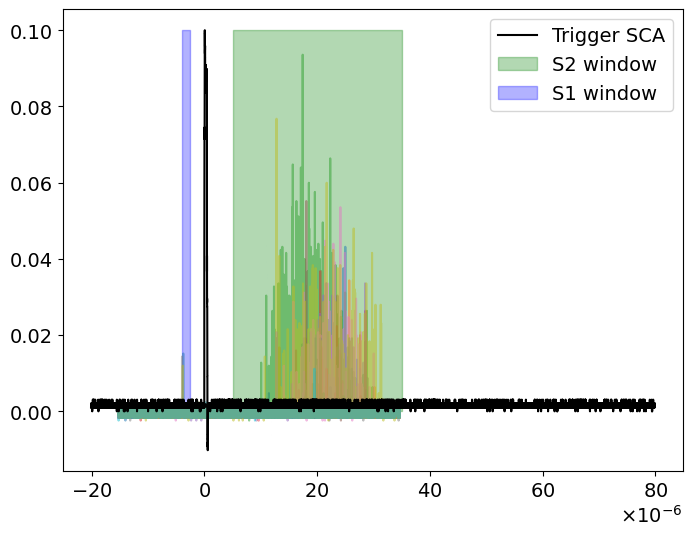

In [7]:
s2_lowcut, s2_upcut = 0.5e-5, 3.5e-5
s1_lowcut, s1_upcut = -0.4e-5, -0.25e-5
bs = -0.000772466
plt.figure(figsize=(8, 6))
for f in files05[:10]:
    wf = wfm2read(f)
    V, t = -wf[0], wf[1]
    V -= bs
    plt.plot(t, V, alpha=0.5)

plt.plot(trig_x, trig_y, label='Trigger SCA', color='black')
plt.fill_betweenx([0, 0.1], x1=s2_lowcut, x2=s2_upcut,
        color='green', alpha=0.3, label='S2 window')

plt.fill_betweenx([0, 0.1], x1=s1_lowcut, x2=s1_upcut,
        color='blue', alpha=0.3, label='S1 window')

# plt.gca().set(xlim=(-1e-5, 3.5e-5), ylim=(-0.005, 0.05), xlabel='t (s)', ylabel='Amplitude (V)')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-6, -6))

# Field scan, low range

In [8]:
path05 = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/FieldScan_1GSsec_EL1450_Gate50'
files05 = sorted(glob(os.path.join(path05, '*.wfm')))

In [11]:
as2 = extract_s2_areas(files05, threshold_bs=0.05, integ_window=(1e-6 ,3.5e-5), bs_t_window=(-1.5e-5, -1.0e-5), bs_v_window=None)
len(as2)

2984

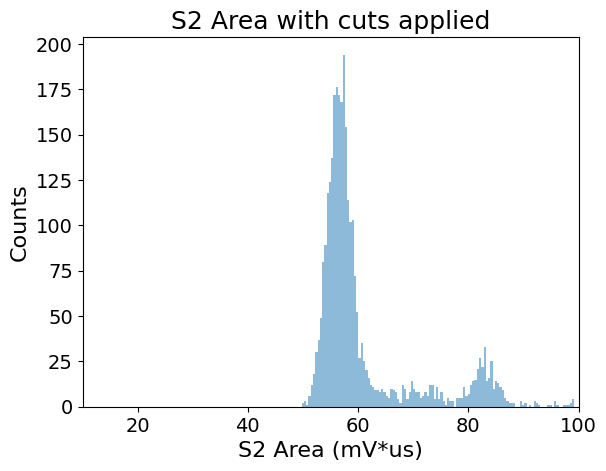

In [13]:
as2_cuts = apply_hist_cuts(as2, -8, 100)
plt.hist(as2_cuts, bins=120, alpha=0.5);
plt.gca().set(xlabel='S2 Area (mV*us)', ylabel='Counts', xlim=(10, 100), title='S2 Area with cuts applied');

In [18]:
import re
voltage_pairs = []
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/'
subdirs = sorted(os.listdir(base_dir))
for subdir in subdirs:
    try:
        gate_voltage = int(re.search(r'Gate(\d+)', subdir).group(1))
        anode_voltage = int(re.search(r'EL(\d+)', subdir).group(1))
        print(f"Anode voltage : {anode_voltage}, Gate voltage : {gate_voltage}")
        voltage_pairs.append((anode_voltage, gate_voltage))
    except AttributeError:
        continue
    

Anode voltage : 1450, Gate voltage : 50
Anode voltage : 1460, Gate voltage : 60
Anode voltage : 1465, Gate voltage : 65
Anode voltage : 1470, Gate voltage : 70
Anode voltage : 1475, Gate voltage : 75
Anode voltage : 1500, Gate voltage : 100
Anode voltage : 1550, Gate voltage : 150
Anode voltage : 1650, Gate voltage : 250
Anode voltage : 1750, Gate voltage : 350
Anode voltage : 1850, Gate voltage : 450
Anode voltage : 1950, Gate voltage : 550
Anode voltage : 2000, Gate voltage : 600
Anode voltage : 2050, Gate voltage : 650
Anode voltage : 2100, Gate voltage : 700
Anode voltage : 2150, Gate voltage : 750
Anode voltage : 2200, Gate voltage : 800
Anode voltage : 2600, Gate voltage : 1200
Anode voltage : 3100, Gate voltage : 1700
Anode voltage : 3600, Gate voltage : 2200
Anode voltage : 4100, Gate voltage : 2700


Integrating 3000 files for EL 1450 V, Gate 50 V
Integrating 3000 files for EL 1460 V, Gate 60 V
Integrating 3324 files for EL 1465 V, Gate 65 V
Integrating 3000 files for EL 1470 V, Gate 70 V
Integrating 3000 files for EL 1475 V, Gate 75 V
Integrating 3000 files for EL 1500 V, Gate 100 V
Integrating 3000 files for EL 1550 V, Gate 150 V
Integrating 3000 files for EL 1650 V, Gate 250 V
Integrating 3000 files for EL 1750 V, Gate 350 V
Integrating 3000 files for EL 1850 V, Gate 450 V
Integrating 3000 files for EL 1950 V, Gate 550 V
Integrating 3000 files for EL 2000 V, Gate 600 V
Integrating 3000 files for EL 2050 V, Gate 650 V
Integrating 3000 files for EL 2100 V, Gate 700 V
Integrating 2997 files for EL 2150 V, Gate 750 V
Integrating 3000 files for EL 2200 V, Gate 800 V
Integrating 3000 files for EL 2600 V, Gate 1200 V
Integrating 3000 files for EL 3100 V, Gate 1700 V
Integrating 3000 files for EL 3600 V, Gate 2200 V
Integrating 3000 files for EL 4100 V, Gate 2700 V


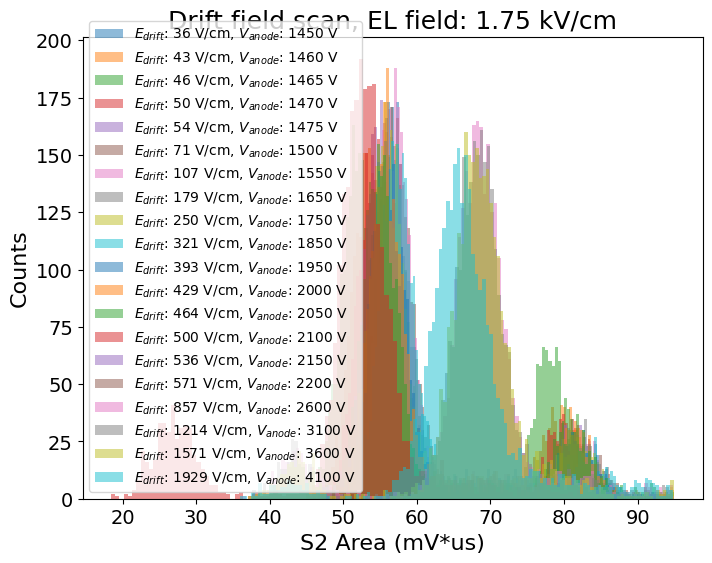

In [19]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/'
pattern = 'FieldScan_1GSsec_EL{}_Gate{}'
s2_lowcut, s2_upcut = 1e-6, 3.5e-5
hist_lowcut, hist_upcut = -8, 95

as2_cuts, as2 = analyse_field_scan(base_dir, voltage_pairs, pattern,
                                  s2_cuts=(s2_lowcut, s2_upcut), hist_cuts=(hist_lowcut, hist_upcut))

In [23]:
for key, a1 in as2_cuts.items():
    print(key)

(1450, 50)
(1460, 60)
(1465, 65)
(1470, 70)
(1475, 75)
(1500, 100)
(1550, 150)
(1650, 250)
(1750, 350)
(1850, 450)
(1950, 550)
(2000, 600)
(2050, 650)
(2100, 700)
(2150, 750)
(2200, 800)
(2600, 1200)
(3100, 1700)
(3600, 2200)
(4100, 2700)


In [37]:
select_pairs = [(1450, 50),
(1460, 60),
(1465, 65),
(1470, 70),
(1475, 75),
(1500, 100),
(1550, 150),
(1650, 250),
(1750, 350),
(1850, 450),
(1950, 550),
(2000, 600),
(2050, 650),]
hiv_pairs = [
# (2100, 700),
(2150, 750),
(2200, 800),
(2600, 1200),
(3100, 1700),
(3600, 2200),
(4100, 2700)]
as2_select = {k: v for k, v in as2_cuts.items() if k in select_pairs}
as2_hiv = {k: v for k, v in as2_cuts.items() if k in hiv_pairs}

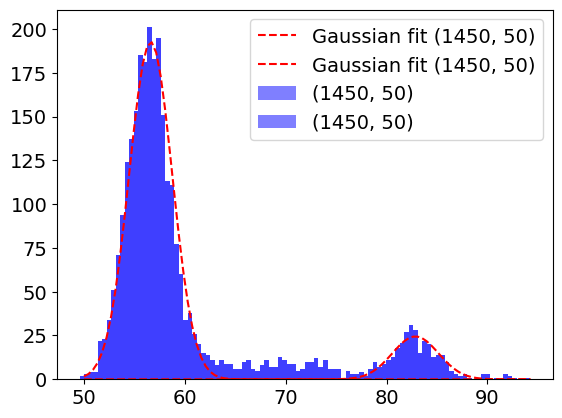

(1450, 50): amplitude=192.67, mean=56.59, sigma=2.14)
(1450, 50): amplitude=24.46, mean=82.85, sigma=2.29)


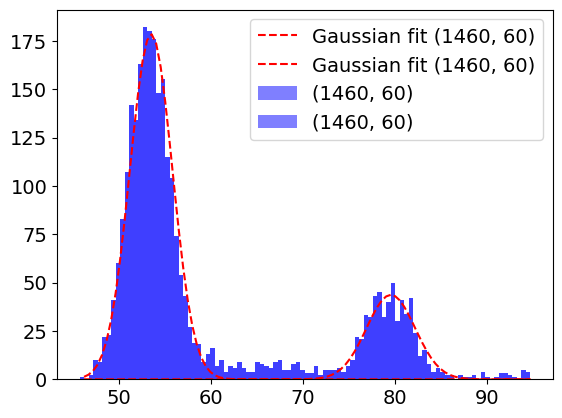

(1460, 60): amplitude=178.43, mean=53.48, sigma=2.32)
(1460, 60): amplitude=43.65, mean=79.53, sigma=2.64)


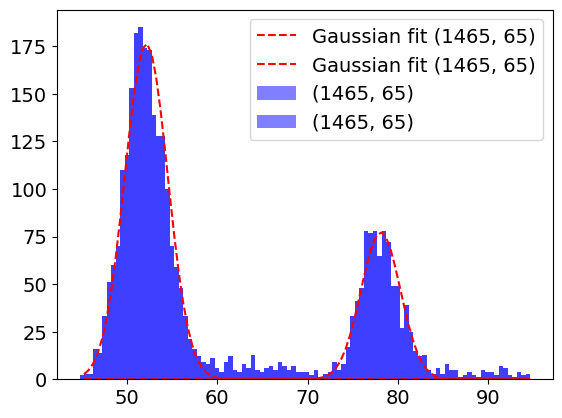

(1465, 65): amplitude=176.42, mean=52.11, sigma=2.38)
(1465, 65): amplitude=77.24, mean=78.12, sigma=2.19)


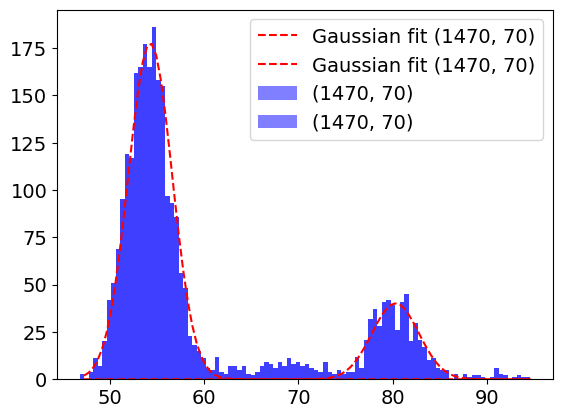

(1470, 70): amplitude=177.65, mean=54.26, sigma=2.33)
(1470, 70): amplitude=40.09, mean=80.29, sigma=2.49)


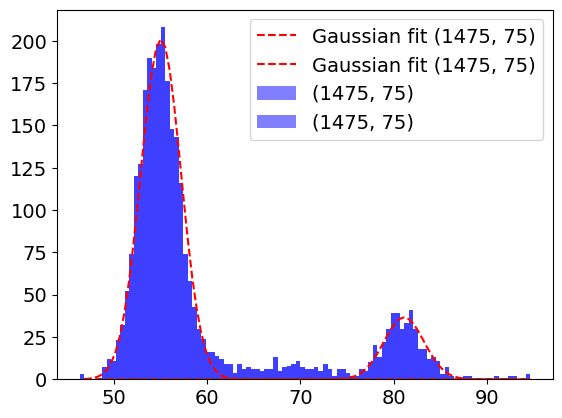

(1475, 75): amplitude=200.87, mean=55.05, sigma=2.16)
(1475, 75): amplitude=36.55, mean=81.09, sigma=2.15)


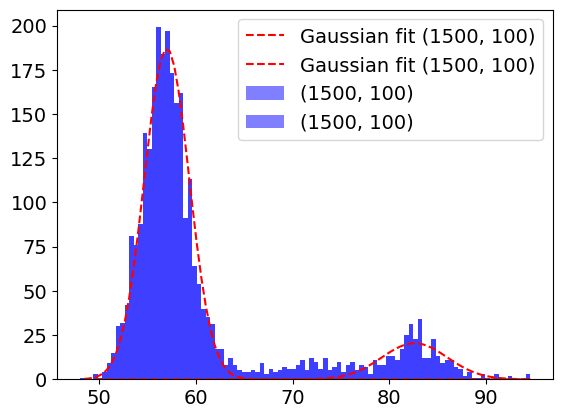

(1500, 100): amplitude=187.07, mean=56.99, sigma=2.33)
(1500, 100): amplitude=20.38, mean=82.63, sigma=3.39)


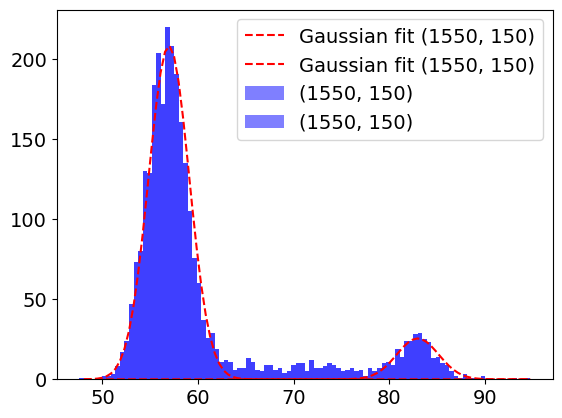

(1550, 150): amplitude=208.43, mean=56.96, sigma=2.13)
(1550, 150): amplitude=25.50, mean=82.98, sigma=2.19)


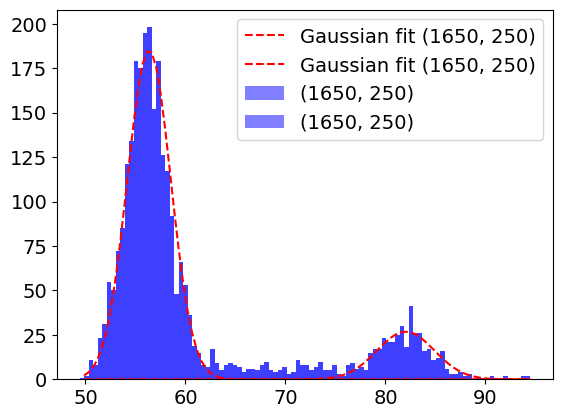

(1650, 250): amplitude=185.20, mean=56.36, sigma=2.18)
(1650, 250): amplitude=26.77, mean=82.03, sigma=2.85)


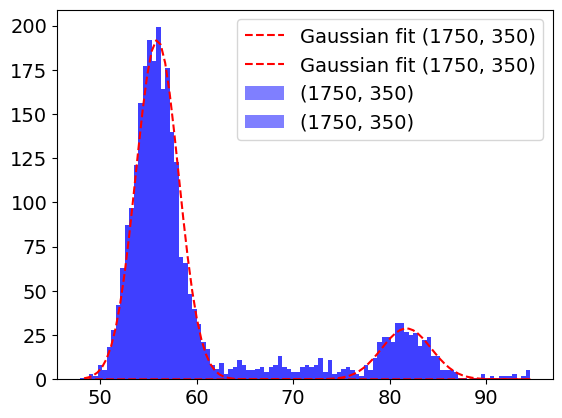

(1750, 350): amplitude=191.81, mean=55.91, sigma=2.21)
(1750, 350): amplitude=28.75, mean=81.75, sigma=2.57)


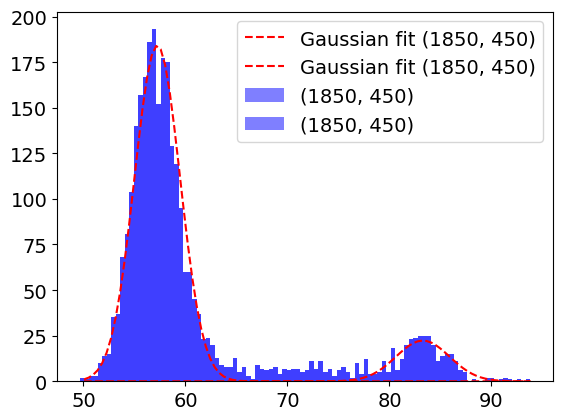

(1850, 450): amplitude=184.07, mean=57.23, sigma=2.24)
(1850, 450): amplitude=22.30, mean=83.27, sigma=2.62)


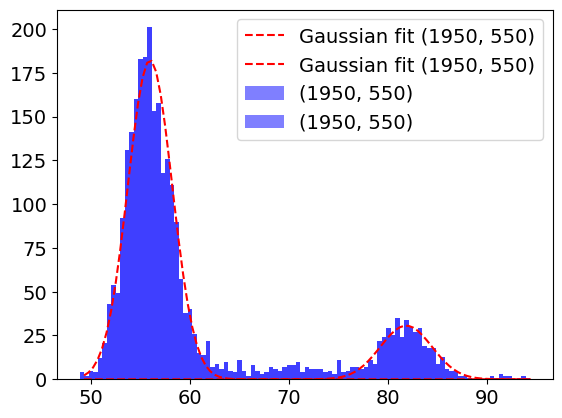

(1950, 550): amplitude=182.30, mean=55.96, sigma=2.24)
(1950, 550): amplitude=30.61, mean=81.84, sigma=2.61)


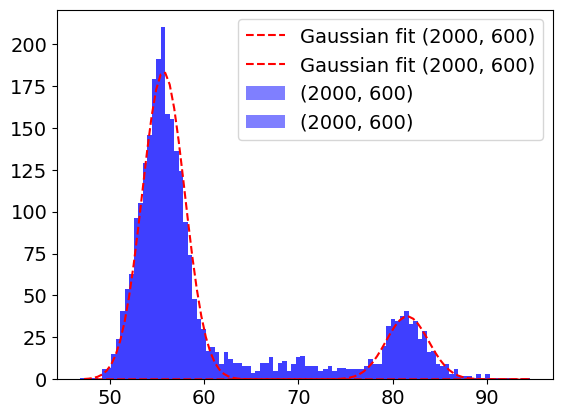

(2000, 600): amplitude=183.45, mean=55.71, sigma=2.25)
(2000, 600): amplitude=37.51, mean=81.57, sigma=2.27)


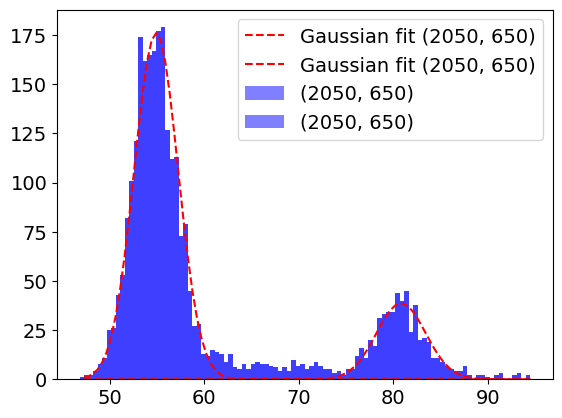

(2050, 650): amplitude=176.04, mean=54.94, sigma=2.32)
(2050, 650): amplitude=38.61, mean=80.84, sigma=2.61)


In [38]:
# as2_cuts = {**as2_cuts_hi, **as2_cuts_mid, **as2_cuts_lo}
# as2_cuts = {**as2_cuts_mid, **as2_cuts_lo}

# Loop over all histograms in as2_cuts and fit/plot
fit_results_rap = {}
fit_results_rapp = {}
# for key, a1 in as2_cuts.items():
for key, a1 in as2_select.items():
    n, bins = np.histogram(a1, bins=100)
    
    try:
        popt_rap, pcov_rap = fit_and_plot_gaussian(n, bins, label=str(key), mask_range=(0, 70), color='blue')
        popt_rapp, pcov_rapp = fit_and_plot_gaussian(n, bins, label=str(key), mask_range=(70, 100), color='blue')
    except ValueError or RuntimeError:
        print(f"Could not fit Gaussian for key {key}")
        continue

    # plt.clf()
    plt.show()

    fit_results_rap[key] = (popt_rap, pcov_rap)
    fit_results_rapp[key] = (popt_rapp, pcov_rapp)
    print(f'{key}: amplitude={popt_rap[0]:.2f}, mean={popt_rap[1]:.2f}, sigma={popt_rap[2]:.2f})')
    print(f'{key}: amplitude={popt_rapp[0]:.2f}, mean={popt_rapp[1]:.2f}, sigma={popt_rapp[2]:.2f})')

Could not fit Gaussian for key (2150, 750)
Could not fit Gaussian for key (2200, 800)


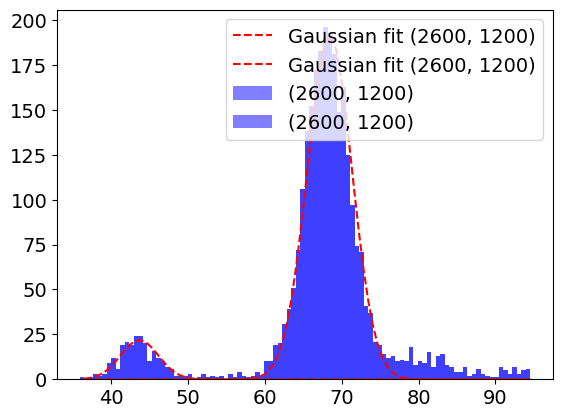

(2600, 1200): amplitude=21.74, mean=43.70, sigma=2.47)
(2600, 1200): amplitude=191.18, mean=68.44, sigma=2.92)


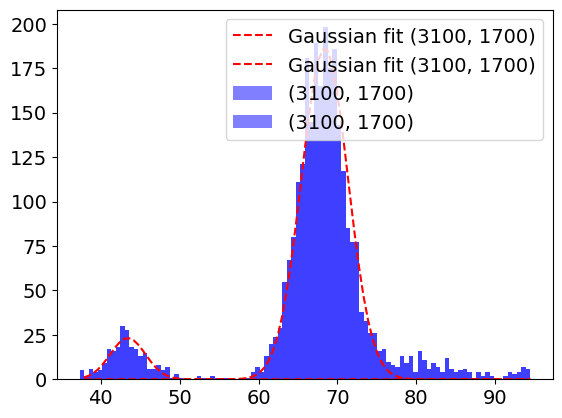

(3100, 1700): amplitude=23.15, mean=43.43, sigma=2.24)
(3100, 1700): amplitude=186.09, mean=68.38, sigma=2.96)


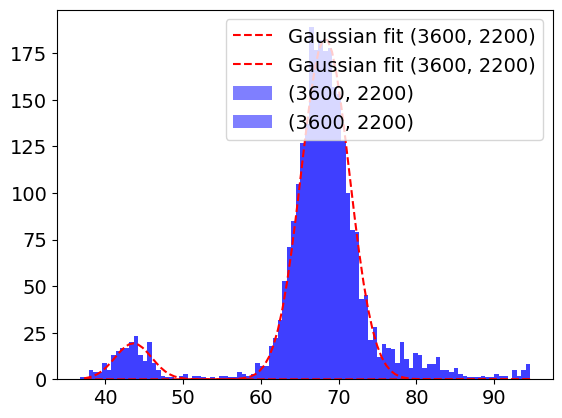

(3600, 2200): amplitude=19.29, mean=43.62, sigma=2.35)
(3600, 2200): amplitude=182.96, mean=68.28, sigma=3.10)


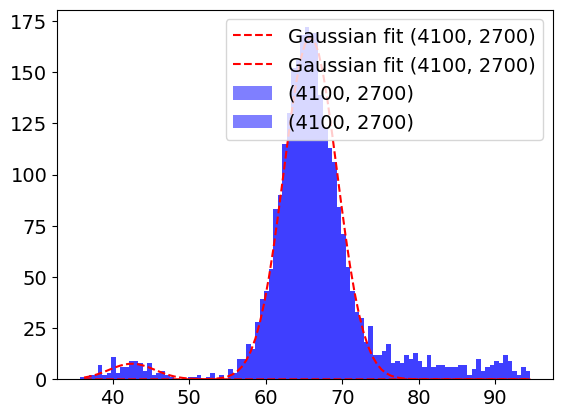

(4100, 2700): amplitude=7.60, mean=42.52, sigma=3.00)
(4100, 2700): amplitude=167.19, mean=65.83, sigma=3.48)


In [39]:
for i, (key, a1) in enumerate(as2_hiv.items()):
    n, bins = np.histogram(a1, bins=100)
    
    try:
        popt_rap, pcov_rap = fit_and_plot_gaussian(n, bins, label=str(key), mask_range=(0, 50), color='blue')
        popt_rapp, pcov_rapp = fit_and_plot_gaussian(n, bins, label=str(key), mask_range=(50, 100), color='blue')
    except ValueError or RuntimeError:
        print(f"Could not fit Gaussian for key {key}")
        continue

    # plt.clf()
    plt.show()

    fit_results_rap[key] = (popt_rap, pcov_rap)
    fit_results_rapp[key] = (popt_rapp, pcov_rapp)
    print(f'{key}: amplitude={popt_rap[0]:.2f}, mean={popt_rap[1]:.2f}, sigma={popt_rap[2]:.2f})')
    print(f'{key}: amplitude={popt_rapp[0]:.2f}, mean={popt_rapp[1]:.2f}, sigma={popt_rapp[2]:.2f})')

[Text(0.5, 0, '$E_{drift}$ (V/cm)'),
 Text(0, 0.5, 'Mean S2 Area (mV$\\cdot$us)'),
 Text(0.5, 1.0, 'Mean S2 Area vs $E_{drift}$ (95% CI)')]

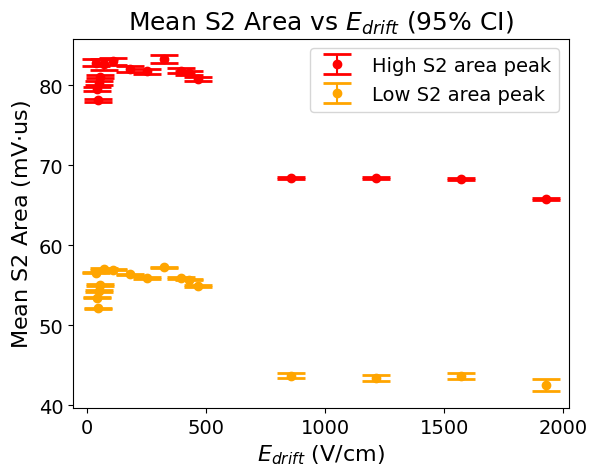

In [40]:
mean_gaussian_rap = []
ci95_gaussian_rap = []


for popt, pcov in fit_results_rap.values():
    mean = popt[1]
    rms = popt[2]
    std_error = np.sqrt(pcov[1, 1])
    ci95 = 1.96 * std_error
    mean_gaussian_rap.append(mean)
    ci95_gaussian_rap.append(ci95)
    # rms_gaussian_rap.append(rms)

mean_gaussian_rapp = []
ci95_gaussian_rapp = []
for popt, pcov in fit_results_rapp.values():
    mean = popt[1]
    rms = popt[2]
    std_error = np.sqrt(pcov[1, 1])
    ci95 = 1.96 * std_error
    mean_gaussian_rapp.append(mean)
    ci95_gaussian_rapp.append(ci95)

E_gate = [f[1]/1.4 for f in fit_results_rap.keys()]
V_gate = [f[1] for f in fit_results_rap.keys()]
plt.errorbar(E_gate, mean_gaussian_rapp, yerr=ci95_gaussian_rapp, fmt='o', color='red', capsize=10, capthick=2, label='High S2 area peak')
plt.errorbar(E_gate, mean_gaussian_rap, yerr=ci95_gaussian_rap, fmt='o', color='orange', capsize=10, capthick=2, label='Low S2 area peak')
# plt.errorbar(V_gate, mean_gaussian_rap, yerr=ci95_gaussian_rap, fmt='o', color='orange', capsize=10, capthick=2)
# plt.errorbar(V_gate, mean_gaussian_rapp, yerr=ci95_gaussian_rapp, fmt='o', color='red', capsize=10, capthick=2)

plt.legend()
plt.gca().set(xlabel='$E_{drift}$ (V/cm)', ylabel='Mean S2 Area (mV$\cdot$us)', 
              title='Mean S2 Area vs $E_{drift}$ (95% CI)', )
            #   xlim=(0, 550), ylim=(-0.7, 0.7))

[Text(0.5, 0, '$E_{drift}$ (V/cm)'),
 Text(0, 0.5, 'Mean S2 Area (mV$\\cdot$us)'),
 Text(0.5, 1.0, 'Mean S2 Area vs $E_{drift}$ (95% CI)')]

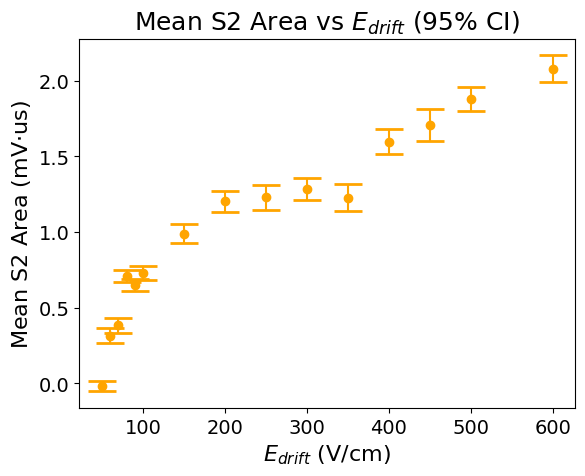

In [ ]:
mean_gaussian = []
ci95_gaussian = []
rms_gaussian = []
for popt, pcov in fit_results.values():
    mean = popt[1]
    rms = popt[2]
    std_error = np.sqrt(pcov[1, 1])
    ci95 = 1.96 * std_error
    mean_gaussian.append(mean)
    ci95_gaussian.append(ci95)
    rms_gaussian.append(rms)

E_gate = [f[1]/1.4 for f in fit_results.keys()]
V_gate = [f[1] for f in fit_results.keys()]
# plt.errorbar(E_gate, mean_gaussian, yerr=ci95_gaussian, fmt='o', color='orange', capsize=10, capthick=2)
plt.errorbar(V_gate, mean_gaussian, yerr=ci95_gaussian, fmt='o', color='orange', capsize=10, capthick=2)

plt.gca().set(xlabel='$E_{drift}$ (V/cm)', ylabel='Mean S2 Area (mV$\cdot$us)', 
              title='Mean S2 Area vs $E_{drift}$ (95% CI)', )
            #   xlim=(0, 550), ylim=(-0.7, 0.7))

In [32]:
path_result = r'E:\Pablos_Mighty_measurements\RUN1\FieldScans\s2_area_ci95.csv'
df = pd.DataFrame({'E_gate': E_gate, 'mean_gaussian': mean_gaussian, 'ci95_gaussian': ci95_gaussian})
df.to_csv(path_result, index=False)

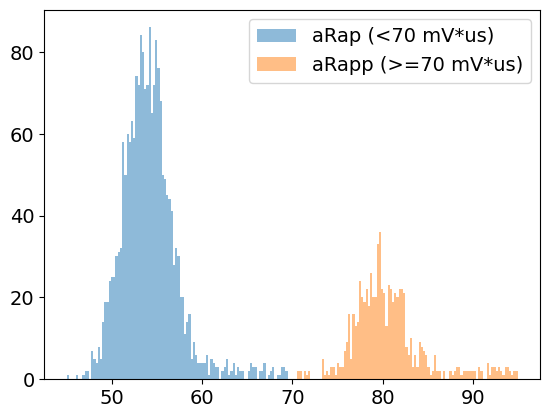

In [251]:
as2_cuts[(2450, 50)]
aRap = as2_cuts[(2450, 50)][as2_cuts[(2450, 50)] < 70]
aRapp = as2_cuts[(2450, 50)][as2_cuts[(2450, 50)] >= 70]
nRap,binsp, _ = plt.hist(aRap, bins=100, alpha=0.5, label='aRap (<70 mV*us)')
nRapp, binspp, _ = plt.hist(aRapp, bins=100, alpha=0.5, label='aRapp (>=70 mV*us)')
plt.legend()

In [253]:
nRapp.sum(), nRap.sum()

(724.0, 2025.0)